# Chinook Music Store Business Analysis


## Background

The purpose of this project is to conduct a business analysis using SQL. **Chinook** is a fictional online music store that wants to improve their performance. Using their database, I will try to answer their questions and provide the most efficient solutions.

Below is a copy of the database schema that shows relationships between the tables:

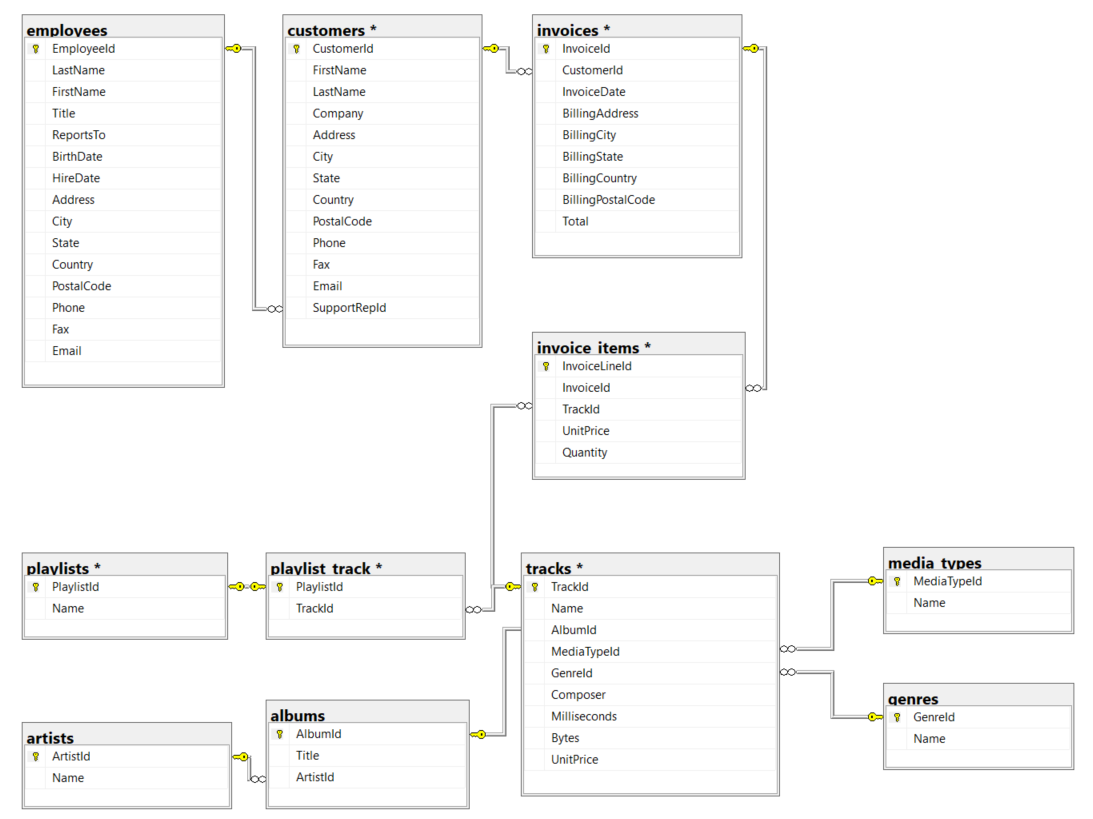

First, let's load the database:

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

Now, let's see if it's working:

In [2]:
%%sql

SELECT * from playlists;

 * sqlite:///chinook.db
Done.


PlaylistId,Name
1,Music
2,Movies
3,TV Shows
4,Audiobooks
5,90’s Music
6,Audiobooks
7,Movies
8,Music
9,Music Videos
10,TV Shows


Looks like it's working fine. Now, we can move on to conducting our analysis.

## Task 1. Selecting albums to purchase

**Overview**

The Chinook record store has just signed a deal with a new record label, and wants to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now. Below are the artist names, and the genre of music they produce:

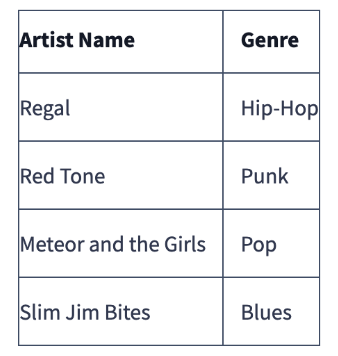

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

**Analysis**

Write a query that returns each genre, with the number of tracks sold in the USA in absolute numbers and in percentages.

In [3]:
%%sql

select g.name, count(ii.trackid) as No_of_Tracks_Sold,
round(count(*) * 100.0 / sum(count(*)) over(), 1) as Percentage_of_All_Sold_Tracks
from genres g
join tracks t on
g.genreid = t.genreid
join invoice_items ii ON
t.trackid = ii.trackid
where ii.invoiceid in (SELECT
i.invoiceid
from invoices i
where billingcountry = "USA")
group by g.name;

 * sqlite:///chinook.db
Done.


Name,No_of_Tracks_Sold,Percentage_of_All_Sold_Tracks
Alternative,5,1.0
Alternative & Punk,50,10.1
Blues,15,3.0
Bossa Nova,7,1.4
Classical,8,1.6
Comedy,8,1.6
Drama,6,1.2
Easy Listening,3,0.6
Heavy Metal,4,0.8
Hip Hop/Rap,4,0.8


**Conclusion**

Let's look at the results above. USA based customers are the most interested in Rock music, which accounts to **31.8%** of all USA sales. The least popular genre is Science Fiction with **0.2%** of all sales.

Now, the genres of the four albums Chinook wants to add to their store are: Hip-Hop, Punk, Pop, and Blues. These genres contribute to **0.8%**, **10.1%**, **1%**, and **3%** of all sales respectively. Basing on the genre sales pattern, Chinook should choose albums from these artists:
* *Red Tone* (Punk)
* *Meteor and the Girls* (Pop)
* *Slim Jim Bites* (Blues)


## Task 2. Analyzing Employee Sales Performance

**Overview**

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Chinook wants to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

**Analysis**

Write a query that finds hire date, number of customers, number of sales, and total dollar amount of sales assigned to each sales support agent within the company.

In [4]:
%%sql

select e.firstname || " " || e.lastname as Employee_Name,
e.hiredate as Hire_Date,
count(distinct i.customerid) as No_of_Customers,
count(i.invoiceid) as No_of_Sales, 
round(sum(i.total), 2) as Total_Sales_Amount_in_$,
round(avg(i.total), 2) as Avg_Sale_Amount_in_$
from employees e
join customers c ON
e.employeeid = c.supportrepid
join invoices i ON
c.customerid = i.customerid
GROUP by e.employeeid;

 * sqlite:///chinook.db
Done.


Employee_Name,Hire_Date,No_of_Customers,No_of_Sales,Total_Sales_Amount_in_$,Avg_Sale_Amount_in_$
Jane Peacock,2018-04-01,21,146,833.04,5.71
Margaret Park,2019-05-03,20,140,775.4,5.54
Steve Johnson,2019-10-17,18,126,720.16,5.72


**Conclusion**

The employee with the highest total amount of sales with **$833.04** is **Jane Peacock**. This is understandable, as she has been hired for the longest period of time. **Steve Johnson** has made **$720.16** with his sales, however, he has joined the company as the last one. 
It is also worth nothing, that **Margaret Park** made only 6 sales less than **Jane Peacock** despite the fact that Jane was hired 13 months earlier than Margaret.
Another important thing is that **Steve** is the one with the highest average sale amount, which may suggest that he is the one with the best performance.


## Task 3. Analyzing Sales by Country

**Overview**

Next task is to analyze the sales data for customers from each different country. Chinook has advised to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

**Analysis**

Write a query that collates data on purchases from different countries.
As there are a number of countries with only one customer, they should be grouped as "Other."
The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
For each country, include:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [6]:
%%sql 

-- Creating a view that changes name of countries with only one customer to "Other."

CREATE VIEW Others AS
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customers
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customerid,
       i.invoiceid,
       i.total
     FROM invoices i
     JOIN customers c ON c.customerid = i.customerid;
 

-- Using the view, I am compiling all "Other" countries into one and placing them at the bottom of the table.

SELECT
    country as Country,
    No_of_Customers,  
    Total_Sales_Value_in_$, 
	Avg_Sales_Value_per_Customer_in_$, 
	Avg_Order_Value_in_$
FROM
    (
    SELECT
        country,
        count(distinct customerid) as No_of_Customers,
        ROUND(sum(total), 2) as Total_Sales_Value_in_$,
        ROUND(sum(total) / count(distinct customerid), 2) as Avg_Sales_Value_per_Customer_in_$,
        ROUND(avg(total), 2) as Avg_Order_Value_in_$,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END sort
    FROM Others
    GROUP BY country
    ORDER BY sort ASC, Total_Sales_Value_in_$ DESC
    );

 * sqlite:///chinook.db
Done.
Done.


Country,No_of_Customers,Total_Sales_Value_in_$,Avg_Sales_Value_per_Customer_in_$,Avg_Order_Value_in_$
USA,13,523.06,40.24,5.75
Canada,8,303.96,37.99,5.43
France,5,195.1,39.02,5.57
Brazil,5,190.1,38.02,5.43
Germany,4,156.48,39.12,5.59
United Kingdom,3,112.86,37.62,5.37
Czech Republic,2,90.24,45.12,6.45
Portugal,2,77.24,38.62,5.52
India,2,75.26,37.63,5.79
Other,15,604.3,40.29,5.76


**Conlusion**

The country with the highest number of customers **(13)** and the highest total sales value **($523.06)** is **USA**.
Excluding USA, on average, customers from **Czech Republic, Germany, and France** tend to spend the most on a single order.
Basing on this information, the company could run a marketing campaign in these countries in order to increase its profits.


## Task 4. Finding the most popular artists

**Overview**

Chinook is preparing to host an event for their customers. The company wants to invite the most popular artists to the event and make a live Q&A session with questions from the audience. For this idea to succeed, Chinook needs to identify 5 artists which tracks are used the most frequently in playlists created by the customers.

**Analysis**

Write a query that collates data on artists used in playlists. Limit the query to the 5 most popular artists.

In [7]:
%%sql

SELECT art.name, count(distinct t.trackid) as Times_Tracks_Were_Used_in_Playlists
from playlist_track pt
left join tracks t ON
pt.trackid = t.trackid
left join albums alb ON
t.albumid = alb.albumid
left join artists art ON
alb.artistid = art.artistid
group by art.name
order by Times_Tracks_Were_Used_in_Playlists desc
limit 5;

 * sqlite:///chinook.db
Done.


Name,Times_Tracks_Were_Used_in_Playlists
Iron Maiden,213
U2,135
Led Zeppelin,114
Metallica,112
Lost,92


Let's also try to find out genres of these artists:

In [8]:
%%sql

-- Creating view for all genres for Iron Maiden

create view Iron_Maiden as
SELECT art.name as Artist, g.name as Genre
from artists art
left join albums alb ON
art.artistid = alb.artistid
left join tracks t ON
alb.albumid = t.albumid
left join genres g ON
t.genreid = g.genreid
where art.name = 'Iron Maiden'
group by Genre
order by Genre;


-- Creating view for all genres for U2

create view U2 as
SELECT art.name as Artist, g.name as Genre
from artists art
left join albums alb ON
art.artistid = alb.artistid
left join tracks t ON
alb.albumid = t.albumid
left join genres g ON
t.genreid = g.genreid
where art.name = 'U2'
group by Genre
order by Genre;


-- Creating view for all genres for Led Zeppelin

create view Led_Zeppelin as
SELECT art.name as Artist, g.name as Genre
from artists art
left join albums alb ON
art.artistid = alb.artistid
left join tracks t ON
alb.albumid = t.albumid
left join genres g ON
t.genreid = g.genreid
where art.name = 'Led Zeppelin'
group by Genre;


-- Creating view for all genres for Metallica

create view Metallica as
SELECT art.name as Artist, g.name as Genre
from artists art
left join albums alb ON
art.artistid = alb.artistid
left join tracks t ON
alb.albumid = t.albumid
left join genres g ON
t.genreid = g.genreid
where art.name = 'Metallica'
group by Genre
order by Genre;


-- Creating view for all genres for Lost

create view Lost as
SELECT art.name as Artist, g.name as Genre
from artists art
left join albums alb ON
art.artistid = alb.artistid
left join tracks t ON
alb.albumid = t.albumid
left join genres g ON
t.genreid = g.genreid
where art.name = 'Lost'
group by Genre
order by Genre;


-- Joining everything into one table
select * from Iron_Maiden
union
select * from U2
union
select * from Led_Zeppelin
union
select * from Metallica
UNION
select * from Lost
order by Artist;

 * sqlite:///chinook.db
Done.
Done.
Done.
Done.
Done.
Done.


Artist,Genre
Iron Maiden,Blues
Iron Maiden,Heavy Metal
Iron Maiden,Metal
Iron Maiden,Rock
Led Zeppelin,Rock
Lost,Drama
Lost,TV Shows
Metallica,Metal
U2,Pop
U2,Rock


**Conclusion**

Basing on above results, **Iron Maiden** is the most popular artist within Chinook's customers. Their tracks were used in playlists **213** times. Furthermore, 3 of 5 artists compose Rock music. Chinook's Marketing Team may consider going with Rock Theme for their event.


## Summary

During this project, Chinook's questions about their business were answered. This business analysis may serve as a guide to improving the company's profitability. 